<img src="../images/logos/xradar_logo.svg" width=250 alt="xradar"></img>

# Xradar Basics


---

## Overview

1. Xradar general overview
1. Radar data IO
2. Radar data georeferencing
3. Data visualization
   

## Prerequisites
| Concepts | Importance | Notes |
| --- | --- | --- |
| [Intro to Xarray](https://foundations.projectpythia.org/core/xarray.html) | Necessary |  Basic features |
| [Radar Cookbook](https://projectpythia.org/radar-cookbook/README.html) | Necessary |  Radar basics |
| [Matplotlib](https://foundations.projectpythia.org/core/matplotlib.html) | Necessary |  Plotting basic features |
- **Time to learn**: 30 minutes
---

## Imports

In [1]:
import xradar as xd
import pyart
import wradlib as wrl

import fsspec
import numpy as np
from xarray.backends.api import open_datatree

import matplotlib.pyplot as plt
import cartopy.crs as ccrs


## You are using the Python ARM Radar Toolkit (Py-ART), an open source
## library for working with weather radar data. Py-ART is partly
## supported by the U.S. Department of Energy as part of the Atmospheric
## Radiation Measurement (ARM) Climate Research Facility, an Office of
## Science user facility.
##
## If you use this software to prepare a publication, please cite:
##
##     JJ Helmus and SM Collis, JORS 2016, doi: 10.5334/jors.119



## Xradar

`Xradar` is a `Python` package developed to streamline the **reading** and **writing** of radar data across various formats, with exports aligned to standards like ODIM_H5 and CfRadial. Born from the **Open Radar Science Community's** collaboration at **ERAD2022**, `Xradar` uses an `xarray-based` data model, compatible with the upcoming **CfRadial2.1/FM301** standard. This ensures seamless integration with other xarray-based software and existing open-source radar processing tools.

### Xradar data model
Xradar leverages the upcoming FM301 standard, a subset of CfRadial2.0, using Xarray to efficiently manage radar data.

#### DataTree Structure (CfRadial2.1/FM301 standard)
Xradar employs `xarray.DataTree` objects to organize radar sweeps within a single structure, where each sweep is an `xarray.Dataset` containing relevant metadata and variables.

<img src="../images/CfRadial2.1.svg" width=500 alt="xradar"></img>

## Xradar importers

Xradar supports several importers to handle different radar data formats. These importers typically include:

- **ODIM_H5**: For reading radar data in the ODIM_H5 format, which is widely used in Europe and supported by the EUMETNET OPERA program.

- **CfRadial**: For importing data in the CfRadial format, which is commonly used in the atmospheric sciences community.

- **SIGMET/IRIS**: For ingesting radar data from SIGMET/IRIS formats, which are used by various weather radar systems globally.

- **GAMIC**: For reading data from GAMIC radars, which use their proprietary format.

For more importers check [here](https://docs.openradarscience.org/projects/xradar/en/stable/importers.html)

Let's find some Italian radar data located at the Erad 2024 Bucket

In [2]:
# Set the URL and path for the cloud
URL = "https://js2.jetstream-cloud.org:8001/"
path = f"pythia/radar/erad2024"

fs = fsspec.filesystem("s3", anon=True, client_kwargs=dict(endpoint_url=URL))

fs.glob(f"{path}/*")

['pythia/radar/erad2024/.DS_Store',
 'pythia/radar/erad2024/20240522_MeteoSwiss_ARPA_Lombardia',
 'pythia/radar/erad2024/baltrad',
 'pythia/radar/erad2024/dda_data',
 'pythia/radar/erad2024/wradlib',
 'pythia/radar/erad2024/zarr_radar']

In [3]:
files = fs.glob(
    "pythia/radar/erad2024/20240522_MeteoSwiss_ARPA_Lombardia/Data/Cband/*.nc"
)
files[:3]

['pythia/radar/erad2024/20240522_MeteoSwiss_ARPA_Lombardia/Data/Cband/MonteLema_202405221300.nc',
 'pythia/radar/erad2024/20240522_MeteoSwiss_ARPA_Lombardia/Data/Cband/MonteLema_202405221305.nc',
 'pythia/radar/erad2024/20240522_MeteoSwiss_ARPA_Lombardia/Data/Cband/MonteLema_202405221310.nc']

In [4]:
radar_files = [f"s3://{i}" for i in files]
radar_files[:3]

['s3://pythia/radar/erad2024/20240522_MeteoSwiss_ARPA_Lombardia/Data/Cband/MonteLema_202405221300.nc',
 's3://pythia/radar/erad2024/20240522_MeteoSwiss_ARPA_Lombardia/Data/Cband/MonteLema_202405221305.nc',
 's3://pythia/radar/erad2024/20240522_MeteoSwiss_ARPA_Lombardia/Data/Cband/MonteLema_202405221310.nc']

In [5]:
local_files = [
    fsspec.open_local(
        f"simplecache::{URL}{i}", s3={"anon": True}, filecache={"cache_storage": "."}
    )
    for i in files
]

We can open one of this `nc` files using `xradar.io.open_cfradial1_datree` method

In [6]:
# with fs.open(radar_files[0], mode="rb", anon=True, client_kwargs=dict(endpoint_url=URL)) as file:
#     dtree = xd.io.open_cfradial1_datatree(file)

In [7]:
dt = xd.io.open_cfradial1_datatree(local_files[0])
display(dt)

DataTree('root', parent=None)
│   Dimensions:              (sweep: 20, frequency: 1)
│   Coordinates:
│     * frequency            (frequency) float32 4B 5.451e+09
│   Dimensions without coordinates: sweep
│   Data variables:
│       sweep_group_name     (sweep) <U8 640B 'sweep_0' 'sweep_1' ... 'sweep_19'
│       sweep_fixed_angle    (sweep) float32 80B ...
│       latitude             float32 4B ...
│       longitude            float32 4B ...
│       altitude             float32 4B ...
│       time_coverage_start  |S32 32B ...
│       time_coverage_end    |S32 32B ...
│       volume_number        int32 4B ...
│   Attributes:
│       Conventions:      CF/Radial instrument_parameters
│       version:          1.3
│       title:            
│       institution:      
│       references:       
│       source:           
│       comment:          
│       instrument_name:  L
│       history:          
├── DataTree('radar_parameters')
│       Dimensions:             ()
│       Data variables:
│           radar_beam_width_v  float32 4B ...
│           radar_beam_width_h  float32 4B ...
├── DataTree('georeferencing_correction')
├── DataTree('sweep_0')
│       Dimensions:                              (azimuth: 360, range: 492)
│       Coordinates:
│           time                                 (azimuth) datetime64[ns] 3kB 2024-05...
│         * range                                (range) float32 2kB 250.0 ... 2.457e+05
│         * azimuth                              (azimuth) float32 1kB 0.5411 ... 359.5
│           elevation                            (azimuth) float32 1kB ...
│           latitude                             float32 4B ...
│           longitude                            float32 4B ...
│           altitude                             float32 4B ...
│       Data variables: (12/14)
│           reflectivity                         (azimuth, range) float64 1MB ...
│           signal_to_noise_ratio                (azimuth, range) float64 1MB ...
│           reflectivity_vv                      (azimuth, range) float64 1MB ...
│           differential_reflectivity            (azimuth, range) float64 1MB ...
│           uncorrected_cross_correlation_ratio  (azimuth, range) float64 1MB ...
│           uncorrected_differential_phase       (azimuth, range) float64 1MB ...
│           ...                                   ...
│           reflectivity_hh_clut                 (azimuth, range) float64 1MB ...
│           sweep_number                         int64 8B ...
│           sweep_fixed_angle                    float32 4B ...
│           sweep_mode                           <U20 80B 'azimuth_surveillance'
│           pulse_width                          (azimuth) timedelta64[ns] 3kB ...
│           nyquist_velocity                     (azimuth) float32 1kB ...
├── DataTree('sweep_1')
│       Dimensions:                              (azimuth: 360, range: 492)
│       Coordinates:
│           time                                 (azimuth) datetime64[ns] 3kB 2024-05...
│         * range                                (range) float32 2kB 250.0 ... 2.457e+05
│         * azimuth                              (azimuth) float32 1kB 0.5521 ... 359.5
│           elevation                            (azimuth) float32 1kB ...
│           latitude                             float32 4B ...
│           longitude                            float32 4B ...
│           altitude                             float32 4B ...
│       Data variables: (12/14)
│           reflectivity                         (azimuth, range) float64 1MB ...
│           signal_to_noise_ratio                (azimuth, range) float64 1MB ...
│           reflectivity_vv                      (azimuth, range) float64 1MB ...
│           differential_reflectivity            (azimuth, range) float64 1MB ...
│           uncorrected_cross_correlation_ratio  (azimuth, range) float64 1MB ...
│           uncorrected_differential_phase       (azimuth, range) float64 1MB ...
│  

In this `Xarray.Datatree` object, the first two nodes contains radar metadata and the others contains `Xarray.Datasets` for each sweeps. 

In [8]:
for sweep in dt.children:
    try:
        print(
            f"{sweep} - elevation {np.round(dt[sweep]['sweep_fixed_angle'].values[...], 1)}"
        )
    except KeyError:
        print(sweep)

radar_parameters
georeferencing_correction
sweep_0 - elevation -0.20000000298023224
sweep_1 - elevation 0.4000000059604645
sweep_2 - elevation 1.0
sweep_3 - elevation 1.600000023841858
sweep_4 - elevation 2.5
sweep_5 - elevation 3.5
sweep_6 - elevation 4.5
sweep_7 - elevation 5.5
sweep_8 - elevation 6.5
sweep_9 - elevation 7.5
sweep_10 - elevation 8.5
sweep_11 - elevation 9.5
sweep_12 - elevation 11.0
sweep_13 - elevation 13.0
sweep_14 - elevation 16.0
sweep_15 - elevation 20.0
sweep_16 - elevation 25.0
sweep_17 - elevation 30.0
sweep_18 - elevation 35.0
sweep_19 - elevation 40.0


Let's explore the `1.0` degrees elevation ('sweep_2')

In [9]:
ds_sw2 = dt["sweep_2"].ds
display(ds_sw2)

<xarray.DatasetView> Size: 13MB
Dimensions:                              (azimuth: 360, range: 492)
Coordinates:
    time                                 (azimuth) datetime64[ns] 3kB 2024-05...
  * range                                (range) float32 2kB 250.0 ... 2.457e+05
  * azimuth                              (azimuth) float32 1kB 0.5356 ... 359.5
    elevation                            (azimuth) float32 1kB ...
    latitude                             float32 4B ...
    longitude                            float32 4B ...
    altitude                             float32 4B ...
Data variables: (12/14)
    reflectivity                         (azimuth, range) float64 1MB ...
    signal_to_noise_ratio                (azimuth, range) float64 1MB ...
    reflectivity_vv                      (azimuth, range) float64 1MB ...
    differential_reflectivity            (azimuth, range) float64 1MB ...
    uncorrected_cross_correlation_ratio  (azimuth, range) float64 1MB ...
    uncorrected_differential_phase       (azimuth, range) float64 1MB ...
    ...                                   ...
    reflectivity_hh_clut                 (azimuth, range) float64 1MB ...
    sweep_number                         int64 8B ...
    sweep_fixed_angle                    float32 4B 1.005
    sweep_mode                           <U20 80B 'azimuth_surveillance'
    pulse_width                          (azimuth) timedelta64[ns] 3kB ...
    nyquist_velocity                     (azimuth) float32 1kB ...

## Xradar visualization

We can make a plot using [`xarray.plot`](https://docs.xarray.dev/en/latest/user-guide/plotting.html) functionality.

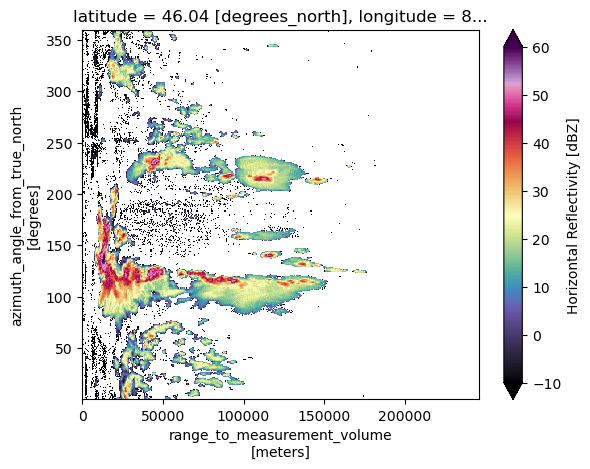

In [10]:
ds_sw2.reflectivity.plot(
    cmap="ChaseSpectral",
    vmax=60,
    vmin=-10,
)

The radar data in the `Xarray.Dataset` object includes range and azimuth as coordinates. To create a radial plot, apply the [`xradar.georeference`](https://docs.openradarscience.org/projects/xradar/en/stable/georeference.html) method. This method will generate x, y, and z coordinates for the plot.

In [11]:
ds_sw2 = ds_sw2.xradar.georeference()
display(ds_sw2)

<xarray.Dataset> Size: 15MB
Dimensions:                              (azimuth: 360, range: 492)
Coordinates:
    time                                 (azimuth) datetime64[ns] 3kB 2024-05...
  * range                                (range) float32 2kB 250.0 ... 2.457e+05
  * azimuth                              (azimuth) float32 1kB 0.5356 ... 359.5
    elevation                            (azimuth) float32 1kB 2.505 ... 2.505
    latitude                             float32 4B 46.04
    longitude                            float32 4B 8.833
    altitude                             float32 4B 1.626e+03
    crs_wkt                              int64 8B 0
    x                                    (azimuth, range) float32 708kB 2.334...
    y                                    (azimuth, range) float32 708kB 249.7...
    z                                    (azimuth, range) float32 708kB 1.637...
Data variables: (12/14)
    reflectivity                         (azimuth, range) float64 1MB ...
    signal_to_noise_ratio                (azimuth, range) float64 1MB ...
    reflectivity_vv                      (azimuth, range) float64 1MB ...
    differential_reflectivity            (azimuth, range) float64 1MB ...
    uncorrected_cross_correlation_ratio  (azimuth, range) float64 1MB ...
    uncorrected_differential_phase       (azimuth, range) float64 1MB ...
    ...                                   ...
    reflectivity_hh_clut                 (azimuth, range) float64 1MB ...
    sweep_number                         int64 8B ...
    sweep_fixed_angle                    float32 4B 1.005
    sweep_mode                           <U20 80B 'azimuth_surveillance'
    pulse_width                          (azimuth) timedelta64[ns] 3kB ...
    nyquist_velocity                     (azimuth) float32 1kB ...

We can now create a radial plot passing `x` and `y` coordinates

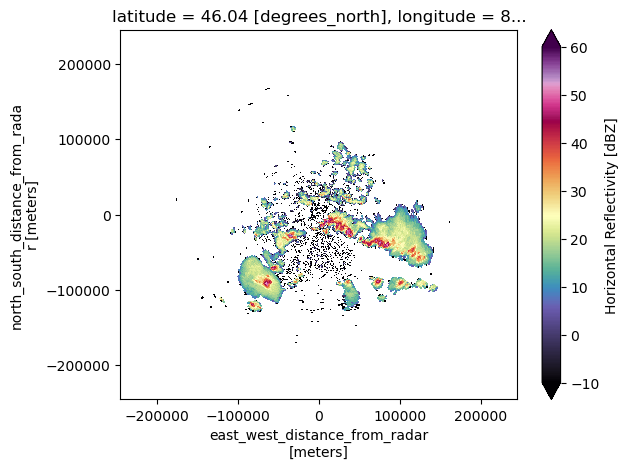

In [12]:
ds_sw2.reflectivity.plot(
    x="x",
    y="y",
    cmap="ChaseSpectral",
    vmax=60,
    vmin=-10,
)

## Data slicing

We can use the power of `Xarray` to acces data within the first 50 kilometers by [slicing](https://foundations.projectpythia.org/core/xarray/xarray-intro.html#slicing-along-coordinates) along coordinates.

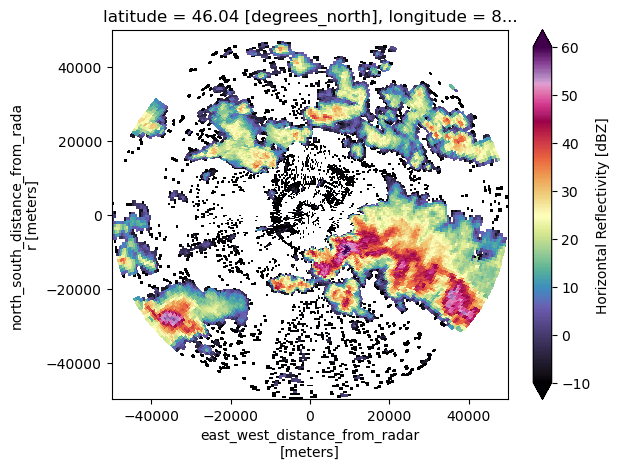

In [13]:
ds_sw2.sel(range=slice(0, 5e4)).reflectivity.plot(
    x="x",
    y="y",
    cmap="ChaseSpectral",
    vmax=60,
    vmin=-10,
)

Let's suposse we want to subset between 90 and 180 degrees angle in azumith

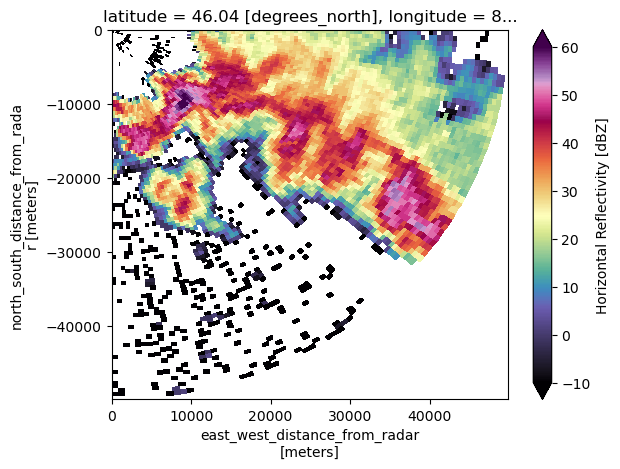

In [14]:
ds_sw2.sel(azimuth=slice(90, 180), range=slice(0, 5e4)).reflectivity.plot(
    x="x",
    y="y",
    cmap="ChaseSpectral",
    vmax=60,
    vmin=-10,
)

Perhaps, we just what to see radar reflectivity along the 100 degrees angle in azimuth

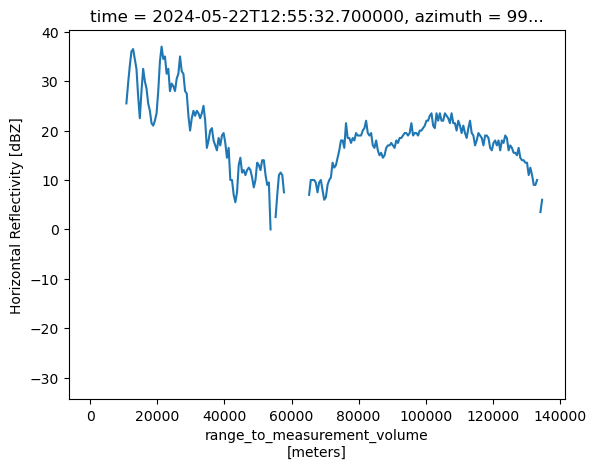

In [15]:
ds_sw2.sel(azimuth=100, method="nearest").reflectivity.plot()

## Xradar integration

### Py-Art

`Xradar` datatree objects can be ported to `Py-ART` radar objects using the pyart.xradar.Xradar method.

/srv/conda/envs/notebook/lib/python3.11/site-packages/xarray/core/dataset.py:4789: UserWarning: No index created for dimension sweep_number because variable sweep_number is not a coordinate. To create an index for sweep_number, please first call `.set_coords('sweep_number')` on this object.
  warnings.warn(


/srv/conda/envs/notebook/lib/python3.11/site-packages/pyart/graph/radarmapdisplay.py:317: UserWarning: No projection was defined for the axes. Overridding defined axes and using default axes with projection Lambert Conformal.
  warnings.warn(


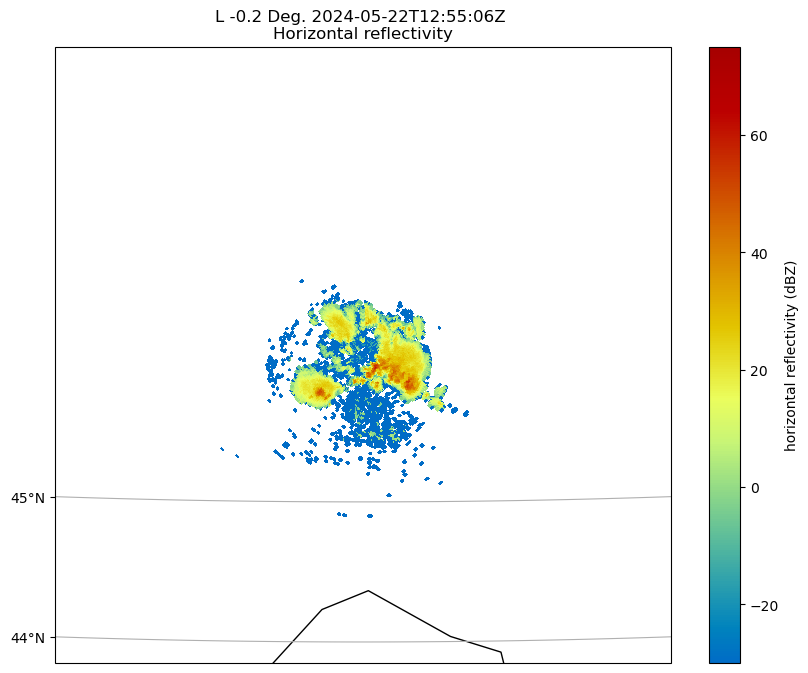

In [16]:
radar = pyart.xradar.Xradar(dt)
fig = plt.figure(figsize=[10, 8])
display = pyart.graph.RadarMapDisplay(radar)
display.plot_ppi_map("reflectivity", sweep=0)

In [17]:
del display

### Wradlib

`Wradlib` functionality can also be applied to `Xarray.Datatree` objects. For example, the [`wradlib.georef`](https://docs.wradlib.org/en/latest/georef.html) module can be used to enrich data by adding geographical coordinates.

In [18]:
for key in list(dt.children):
    if "sweep" in key:
        dt[key].ds = dt[key].ds.wrl.georef.georeference(
            crs=wrl.georef.get_default_projection()
        )

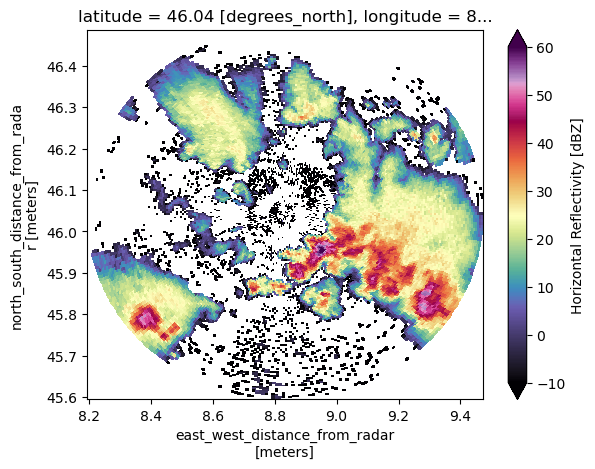

In [19]:
dt["sweep_0"].ds.reflectivity.sel(range=slice(0, 5e4)).plot(
    x="x",
    y="y",
    cmap="ChaseSpectral",
    vmax=60,
    vmin=-10,
)

## Xradar exporters

In xradar, exporters convert radar data into various formats for analysis or integration. Exporting is supported for recognized standards, including:

- CfRadial1
- CfRadial2
- ODIM
- Zarr

Although [`Zarr`](https://zarr.readthedocs.io/en/stable/getting_started.html) is not a traditional standard format, it provides an analysis-ready, cloud-optimized format that enhances data accessibility and performance. 

In [20]:
dt.to_zarr("tree.zarr", consolidated=True, mode="w")

In [21]:
dt_back = open_datatree("tree.zarr", engine="zarr", chunks={})

In [22]:
display(dt_back)

<xarray.DataTree>
Group: /
│   Dimensions:              (frequency: 1, sweep: 20)
│   Coordinates:
│     * frequency            (frequency) float32 4B 5.451e+09
│   Dimensions without coordinates: sweep
│   Data variables:
│       altitude             float32 4B ...
│       latitude             float32 4B ...
│       longitude            float32 4B ...
│       sweep_fixed_angle    (sweep) float32 80B dask.array<chunksize=(20,), meta=np.ndarray>
│       sweep_group_name     (sweep) <U8 640B dask.array<chunksize=(20,), meta=np.ndarray>
│       time_coverage_end    |S32 32B ...
│       time_coverage_start  |S32 32B ...
│       volume_number        int32 4B ...
│   Attributes:
│       Conventions:      CF/Radial instrument_parameters
│       comment:          
│       history:          
│       institution:      
│       instrument_name:  L
│       references:       
│       source:           
│       title:            
│       version:          1.3
├── Group: /georeferencing_correction
├── Group: /radar_parameters
│       Dimensions:             (frequency: 1, sweep: 20)
│       Coordinates:
│         * frequency           (frequency) float32 4B 5.451e+09
│       Dimensions without coordinates: sweep
│       Data variables:
│           radar_beam_width_h  float32 4B ...
│           radar_beam_width_v  float32 4B ...
├── Group: /sweep_0
│       Dimensions:                              (frequency: 1, sweep: 20,
│                                                 azimuth: 360, range: 492)
│       Coordinates: (12/15)
│         * frequency                            (frequency) float32 4B 5.451e+09
│           altitude                             float32 4B ...
│         * azimuth                              (azimuth) float32 1kB 0.5411 ... 359.5
│           bins                                 (azimuth, range) float32 708kB dask.array<chunksize=(180, 246), meta=np.ndarray>
│           crs_wkt                              int64 8B ...
│           elevation                            (azimuth) float32 1kB dask.array<chunksize=(360,), meta=np.ndarray>
│           ...                                   ...
│         * range                                (range) float32 2kB 250.0 ... 2.457e+05
│           rays                                 (azimuth, range) float32 708kB dask.array<chunksize=(180, 246), meta=np.ndarray>
│           time                                 (azimuth) datetime64[ns] 3kB dask.array<chunksize=(360,), meta=np.ndarray>
│           x                                    (azimuth, range) float64 1MB dask.array<chunksize=(180, 246), meta=np.ndarray>
│           y                                    (azimuth, range) float64 1MB dask.array<chunksize=(180, 246), meta=np.ndarray>
│           z                                    (azimuth, range) float64 1MB dask.array<chunksize=(180, 246), meta=np.ndarray>
│       Dimensions without coordinates: sweep
│       Data variables: (12/14)
│           differential_reflectivity            (azimuth, range) float64 1MB dask.array<chunksize=(180, 246), meta=np.ndarray>
│           nyquist_velocity                     (azimuth) float32 1kB dask.array<chunksize=(360,), meta=np.ndarray>
│           pulse_width                          (azimuth) timedelta64[ns] 3kB dask.array<chunksize=(360,), meta=np.ndarray>
│           reflectivity                         (azimuth, range) float64 1MB dask.array<chunksize=(180, 246), meta=np.ndarray>
│           reflectivity_hh_clut                 (azimuth, range) float64 1MB dask.array<chunksize=(180, 246), meta=np.ndarray>
│           reflectivity_vv                      (azimuth, range) float64 1MB dask.array<chunksize=(180, 246), meta=np.ndarray>
│           ...                                   ...
│           sweep_fixed_angle                    float32 4B ...
│           sweep_mode                           <U20 80B ...
│           sweep_number                         int64 8B ...
│           uncorrected_cross_correlation_ratio  (azimuth, range) f

---

## Summary

`Xradar` is a Python library designed for working with radar data. It extends xarray to include radar-specific functionality, such as purpose-based accessors and georeferencing methods. It supports exporting data in various formats, including CfRadial1, CfRadial2, ODIM, and Zarr. xradar facilitates the analysis, visualization, and integration of radar data with other tools and systems.

## Resources and references
 - [Xradar](https://docs.openradarscience.org/projects/xradar/en/stable/index.html)
 - [Radar cookbook](https://github.com/ProjectPythia/radar-cookbook)
 - [Py-Art landing page](https://arm-doe.github.io/pyart/)
 - [Wradlib landing page](https://docs.wradlib.org/en/latest/index.html)
